# Testing custom Image Captioning transformer

## Creating Dataset

In [29]:
import json
import os

captions = [
    {"file_name": "maradona.jpeg", "text": "Maradona after winning the 1986 FIFA World Cup with Argentina"},
    {"file_name": "messi.jpg", "text": "Messi with Argentina at the 2022 FIFA World Cup"},
    {"file_name": "pirlo.jpg", "text": "Pirlo with Juventus in 2014"},
    {"file_name": "ronaldo.jpg", "text": "Ronaldo with Portugal at the 2018 World Cup"},
    {"file_name": "ronaldo_.jpg", "text": "Ronaldo won La Liga in his first season and received the Pichichi Trophy in his second."},
    {"file_name": "zidane.jpg", "text": "Zinédine Zidane pendant la finale de la Coupe du monde 2006."},
    ]

# path to the folder containing the images
root = r'C:/Users/likhi/Documents/01 Pycharm Code Folder/001 Master Thesis/01 Dataset/01 Amazon/06a Image Captioning test dataset/imagefolder/train/'

print(os.path.exists(root))

# add metadata.jsonl file to this folder
with open(root + "metadata.jsonl", 'w') as f:
    for item in captions:
        f.write(json.dumps(item) + "\n")

True


In [30]:
from datasets import load_dataset

dataset = load_dataset("imagefolder", data_dir=root, split="train")

Generating train split: 0 examples [00:00, ? examples/s]

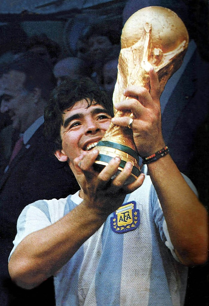

'Maradona after winning the 1986 FIFA World Cup with Argentina'

In [31]:
example = dataset[0]
image = example["image"]
width, height = image.size
display(image.resize((int(0.3*width), int(0.3*height))))

example["text"]

## Create PyTorch Dataset

In [ ]:
from torch.utils.data import Dataset

class ImageCaptioningDataset(Dataset):
    def __init__(self, dataset, processor):
        self.dataset = dataset
        self.processor = processor

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        item = self.dataset[idx]

        encoding = self.processor(images=item["image"], text=item["text"], padding="max_length", return_tensors="pt")

        # remove batch dimension
        encoding = {k:v.squeeze() for k,v in encoding.items()}

        return encoding


from transformers import AutoProcessor

processor = AutoProcessor.from_pretrained("microsoft/git-base")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/503 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/453 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

In [ ]:
train_dataset = ImageCaptioningDataset(dataset, processor)
item = train_dataset[0]
for k,v in item.items():
    print(k,v.shape)

Unused or unrecognized kwargs: padding.


input_ids torch.Size([512])
attention_mask torch.Size([512])
pixel_values torch.Size([3, 224, 224])


## Creating PyTorch Dataloader

In [ ]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=2)

batch = next(iter(train_dataloader))
for k,v in batch.items():
    print(k,v.shape)

Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


input_ids torch.Size([2, 512])
attention_mask torch.Size([2, 512])
pixel_values torch.Size([2, 3, 224, 224])


In [ ]:
processor.decode(batch["input_ids"][0])

'[CLS] maradona after winning the 1986 fifa world cup with argentina [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [

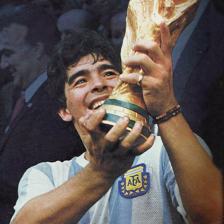

In [ ]:
from PIL import Image
import numpy as np

MEAN = np.array([123.675, 116.280, 103.530]) / 255
STD = np.array([58.395, 57.120, 57.375]) / 255

unnormalized_image = (batch["pixel_values"][0].numpy() * np.array(STD)[:, None, None]) + np.array(MEAN)[:, None, None]
unnormalized_image = (unnormalized_image * 255).astype(np.uint8)
unnormalized_image = np.moveaxis(unnormalized_image, 0, -1)
Image.fromarray(unnormalized_image)

## Define model

In [ ]:
from transformers import AutoModelForCausalLM

model = AutoModelForCausalLM.from_pretrained("microsoft/git-base")

config.json:   0%|          | 0.00/2.82k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/707M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/141 [00:00<?, ?B/s]

In [ ]:
outputs = model(input_ids=batch["input_ids"],
                attention_mask=batch["attention_mask"],
                pixel_values=batch["pixel_values"],
                labels=batch["input_ids"])
outputs.loss

tensor(12.1282, grad_fn=<NllLossBackward0>)

## Train the model

In [ ]:
import torch

optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

model.train()

for epoch in range(10):
  print("Epoch:", epoch)
  for idx, batch in enumerate(train_dataloader):
    input_ids = batch.pop("input_ids").to(device)
    pixel_values = batch.pop("pixel_values").to(device)

    outputs = model(input_ids=input_ids,
                    pixel_values=pixel_values,
                    labels=input_ids)

    loss = outputs.loss

    print("Loss:", loss.item())

    loss.backward()

    optimizer.step()
    optimizer.zero_grad()

Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Epoch: 0
Loss: 9.50487995147705


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 9.142566680908203


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 8.903890609741211


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Epoch: 1
Loss: 8.680744171142578


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 8.463513374328613


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 8.375571250915527


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Epoch: 2
Loss: 8.246962547302246


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 8.084892272949219


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 8.034027099609375


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Epoch: 3
Loss: 7.930660724639893


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 7.817891597747803


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 7.670485496520996


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Epoch: 4
Loss: 7.593823432922363


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 7.476579189300537


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 7.427051544189453


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Epoch: 5
Loss: 7.233198165893555


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 7.209660530090332


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 7.118678569793701


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Epoch: 6
Loss: 6.9335174560546875


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 6.890167713165283


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 6.7913498878479


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Epoch: 7
Loss: 6.650238513946533


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 6.576192855834961


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 6.44590425491333


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Epoch: 8
Loss: 6.342421531677246


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 6.271058559417725


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 6.091109275817871


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Epoch: 9
Loss: 6.033184051513672


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 5.896238327026367


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 5.792816162109375


## Inference

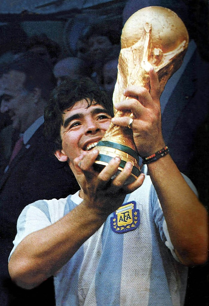

'Maradona after winning the 1986 FIFA World Cup with Argentina'

In [ ]:
example = dataset[0]
image = example["image"]
width, height = image.size
display(image.resize((int(0.3*width), int(0.3*height))))

example["text"]

In [ ]:
# prepare image for the model
inputs = processor(images=image, return_tensors="pt").to(device)
pixel_values = inputs.pixel_values

generated_ids = model.generate(pixel_values=pixel_values, max_length=50)
generated_caption = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
print(generated_caption)

maradona after winning the 1986 fifa world cup with argentina


# Fine-tuning Smart-Assist Image Captioning model

The purpose of creating a fine-tuned Image Captioning model is to enable the chatbot model to identify features that are implicitly mentioned in the text but not explicitly stated. This could include attributes like color, shape, size, material, etc.

## Loading the dataset

In [10]:
# path to the folder containing the images
import os

root = r"C:/Users/likhi/Documents/02 Pycharm Datasets/01 Master Thesis/06b Image_Captioning_Dataset/imagefolder/"

print(os.path.exists(root))

True


In [11]:
import os

# Set the environment variable ARROW_LARGE_MEMORY_TEST to '20GB'
os.environ['ARROW_LARGE_MEMORY_TEST'] = '100GB'

block_size = os.environ.get('ARROW_LARGE_MEMORY_TEST')
print(block_size)

100GB


In [12]:
from datasets import load_dataset

# Define the paths to your train, validation, and test data directories
train_data_path = root +'train/'
val_data_path = root +'val/'
test_data_path = root +'test/'

# Load the train, validation, and test datasets
train_dataset = load_dataset("imagefolder", data_dir=train_data_path, trust_remote_code=True, num_proc=-1)
val_dataset = load_dataset("imagefolder", data_dir=val_data_path, trust_remote_code=True, num_proc=-1)
test_dataset = load_dataset("imagefolder", data_dir=test_data_path, trust_remote_code=True, num_proc=-1)

# Optionally, you can inspect the loaded datasets
print("Train Dataset:")
print(train_dataset)
print("Validation Dataset:")
print(val_dataset)
print("Test Dataset:")
print(test_dataset)


KeyboardInterrupt



In [ ]:
from datasets import load_dataset

dataset = load_dataset("imagefolder", data_dir=root, trust_remote_code=True, num_proc=-1)

## cache location
# C:\Users\likhi\.cache\huggingface\datasets\imagefolder\default-86f5c69dc3f56909\0.0.0\7b7ce5247a942be131d49ad4f3de5866083399a0f250901bd8dc202f8c5f7ce5_builder.lock

In [ ]:
dataset.keys()

In [ ]:
example = train_dataset[2]
image = example["image"]
width, height = image.size
display(image.resize((int(0.3*width), int(0.3*height))))

example["text"]

## Create PyTorch dataset

In [38]:
from torch.utils.data import Dataset

class ImageCaptioningDataset(Dataset):
    def __init__(self, dataset, processor):
        self.dataset = dataset
        self.processor = processor

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        item = self.dataset[idx]

        encoding = self.processor(images=item["image"], text=item["text"], padding="max_length", return_tensors="pt")

        # remove batch dimension
        encoding = {k:v.squeeze() for k,v in encoding.items()}

        return encoding


from transformers import AutoProcessor

processor = AutoProcessor.from_pretrained("microsoft/git-base")

DEBUG:tensorflow:Falling back to TensorFlow client; we recommended you install the Cloud TPU client directly with pip install cloud-tpu-client.
DEBUG:h5py._conv:Creating converter from 7 to 5
DEBUG:h5py._conv:Creating converter from 5 to 7
DEBUG:h5py._conv:Creating converter from 7 to 5
DEBUG:h5py._conv:Creating converter from 5 to 7

DEBUG:urllib3.connectionpool:Starting new HTTPS connection (1): huggingface.co:443
DEBUG:urllib3.connectionpool:https://huggingface.co:443 "HEAD /microsoft/git-base/resolve/main/preprocessor_config.json HTTP/1.1" 200 0
DEBUG:filelock:Attempting to acquire lock 2657409341392 on C:\Users\likhi\.cache\huggingface\hub\.locks\models--microsoft--git-base\f1d9f05041045bd5bc93b72cce5fdcb7d8d254b3.lock
DEBUG:filelock:Lock 2657409341392 acquired on C:\Users\likhi\.cache\huggingface\hub\.locks\models--microsoft--git-base\f1d9f05041045bd5bc93b72cce5fdcb7d8d254b3.lock
DEBUG:urllib3.connectionpool:https://huggingface.co:443 "GET /microsoft/git-base/resolve/main/preproc

preprocessor_config.json:   0%|          | 0.00/503 [00:00<?, ?B/s]

C:\Users\likhi\Documents\01 Pycharm Code Folder\edhec\Lib\site-packages\huggingface_hub\file_download.py:149: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\likhi\.cache\huggingface\hub\models--microsoft--git-base. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
DEBUG:filelock:Attempting to release lock 2657409341392 on C:\Users\likhi\.cache\huggingface

tokenizer_config.json:   0%|          | 0.00/453 [00:00<?, ?B/s]

DEBUG:filelock:Attempting to release lock 2657409344336 on C:\Users\likhi\.cache\huggingface\hub\.locks\models--microsoft--git-base\fb032e4da9ff963eb4e6d476fd3d6ef8d016087c.lock
DEBUG:filelock:Lock 2657409344336 released on C:\Users\likhi\.cache\huggingface\hub\.locks\models--microsoft--git-base\fb032e4da9ff963eb4e6d476fd3d6ef8d016087c.lock
DEBUG:urllib3.connectionpool:https://huggingface.co:443 "HEAD /microsoft/git-base/resolve/main/vocab.txt HTTP/1.1" 200 0
DEBUG:filelock:Attempting to acquire lock 2656201420880 on C:\Users\likhi\.cache\huggingface\hub\.locks\models--microsoft--git-base\fb140275c155a9c7c5a3b3e0e77a9e839594a938.lock
DEBUG:filelock:Lock 2656201420880 acquired on C:\Users\likhi\.cache\huggingface\hub\.locks\models--microsoft--git-base\fb140275c155a9c7c5a3b3e0e77a9e839594a938.lock
DEBUG:urllib3.connectionpool:https://huggingface.co:443 "GET /microsoft/git-base/resolve/main/vocab.txt HTTP/1.1" 200 231508


vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

DEBUG:filelock:Attempting to release lock 2656201420880 on C:\Users\likhi\.cache\huggingface\hub\.locks\models--microsoft--git-base\fb140275c155a9c7c5a3b3e0e77a9e839594a938.lock
DEBUG:filelock:Lock 2656201420880 released on C:\Users\likhi\.cache\huggingface\hub\.locks\models--microsoft--git-base\fb140275c155a9c7c5a3b3e0e77a9e839594a938.lock
DEBUG:urllib3.connectionpool:https://huggingface.co:443 "HEAD /microsoft/git-base/resolve/main/tokenizer.json HTTP/1.1" 200 0
DEBUG:filelock:Attempting to acquire lock 2657360601808 on C:\Users\likhi\.cache\huggingface\hub\.locks\models--microsoft--git-base\688882a79f44442ddc1f60d70334a7ff5df0fb47.lock
DEBUG:filelock:Lock 2657360601808 acquired on C:\Users\likhi\.cache\huggingface\hub\.locks\models--microsoft--git-base\688882a79f44442ddc1f60d70334a7ff5df0fb47.lock
DEBUG:urllib3.connectionpool:https://huggingface.co:443 "GET /microsoft/git-base/resolve/main/tokenizer.json HTTP/1.1" 200 711396


tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

DEBUG:filelock:Attempting to release lock 2657360601808 on C:\Users\likhi\.cache\huggingface\hub\.locks\models--microsoft--git-base\688882a79f44442ddc1f60d70334a7ff5df0fb47.lock
DEBUG:filelock:Lock 2657360601808 released on C:\Users\likhi\.cache\huggingface\hub\.locks\models--microsoft--git-base\688882a79f44442ddc1f60d70334a7ff5df0fb47.lock
DEBUG:urllib3.connectionpool:https://huggingface.co:443 "HEAD /microsoft/git-base/resolve/main/added_tokens.json HTTP/1.1" 404 0
DEBUG:urllib3.connectionpool:https://huggingface.co:443 "HEAD /microsoft/git-base/resolve/main/special_tokens_map.json HTTP/1.1" 200 0
DEBUG:filelock:Attempting to acquire lock 2656851062736 on C:\Users\likhi\.cache\huggingface\hub\.locks\models--microsoft--git-base\a8b3208c2884c4efb86e49300fdd3dc877220cdf.lock
DEBUG:filelock:Lock 2656851062736 acquired on C:\Users\likhi\.cache\huggingface\hub\.locks\models--microsoft--git-base\a8b3208c2884c4efb86e49300fdd3dc877220cdf.lock
DEBUG:urllib3.connectionpool:https://huggingface.c

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

DEBUG:filelock:Attempting to release lock 2656851062736 on C:\Users\likhi\.cache\huggingface\hub\.locks\models--microsoft--git-base\a8b3208c2884c4efb86e49300fdd3dc877220cdf.lock
DEBUG:filelock:Lock 2656851062736 released on C:\Users\likhi\.cache\huggingface\hub\.locks\models--microsoft--git-base\a8b3208c2884c4efb86e49300fdd3dc877220cdf.lock


In [39]:
train_dataset = ImageCaptioningDataset(dataset, processor)
item = train_dataset[0]
for k,v in item.items():
    print(k,v.shape)

DEBUG:PIL.TiffImagePlugin:tag: ExifIFD (34665) - type: long (4) - value: b'\x1a\x00\x00\x00'


input_ids torch.Size([512])
attention_mask torch.Size([512])
pixel_values torch.Size([3, 224, 224])


## Creating PyTorch Dataloader

In [40]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=2)

batch = next(iter(train_dataloader))
for k,v in batch.items():
    print(k,v.shape)

DEBUG:PIL.TiffImagePlugin:tag: ExifIFD (34665) - type: long (4) - value: b'\x1a\x00\x00\x00'


input_ids torch.Size([2, 512])
attention_mask torch.Size([2, 512])
pixel_values torch.Size([2, 3, 224, 224])


In [41]:
processor.decode(batch["input_ids"][0])

'[CLS] 4469 cousin nylon jaw craft and jewelry pliers green 12 1arts crafts sewingbeading jewelry makingjewelry making tools accessoriesjewelry pliers these nylon jawed pliers have many uses and will not damage soft metal findings like sterling comfort padded handles and durable double leaf spring construction they can also be used to straighten bent wires and pins simply draw the wire through the jaws turn and draw again to take out the kinks reduce the gauge of sterling wire by repeatedly drawing the wire through the jaws opens to 75 inches overall size in in brand is cousinmaterial is metalproduct dimensions is 815l 3whandle material is metalitem weight is 01 kilogramsspecific uses for product is wire wrappinggrip type is padded [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] 

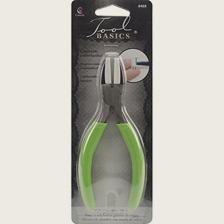

In [42]:
from PIL import Image
import numpy as np

MEAN = np.array([123.675, 116.280, 103.530]) / 255
STD = np.array([58.395, 57.120, 57.375]) / 255

unnormalized_image = (batch["pixel_values"][0].numpy() * np.array(STD)[:, None, None]) + np.array(MEAN)[:, None, None]
unnormalized_image = (unnormalized_image * 255).astype(np.uint8)
unnormalized_image = np.moveaxis(unnormalized_image, 0, -1)
Image.fromarray(unnormalized_image)

### Defining the model

In [43]:
from transformers import AutoModelForCausalLM

model = AutoModelForCausalLM.from_pretrained("microsoft/git-base")

DEBUG:urllib3.connectionpool:https://huggingface.co:443 "HEAD /microsoft/git-base/resolve/main/config.json HTTP/1.1" 200 0
DEBUG:filelock:Attempting to acquire lock 2656307469776 on C:\Users\likhi\.cache\huggingface\hub\.locks\models--microsoft--git-base\25680694d145c7902098f2bcdd81c23d4fc8e598.lock
DEBUG:filelock:Lock 2656307469776 acquired on C:\Users\likhi\.cache\huggingface\hub\.locks\models--microsoft--git-base\25680694d145c7902098f2bcdd81c23d4fc8e598.lock
DEBUG:urllib3.connectionpool:https://huggingface.co:443 "GET /microsoft/git-base/resolve/main/config.json HTTP/1.1" 200 2822


config.json:   0%|          | 0.00/2.82k [00:00<?, ?B/s]

DEBUG:filelock:Attempting to release lock 2656307469776 on C:\Users\likhi\.cache\huggingface\hub\.locks\models--microsoft--git-base\25680694d145c7902098f2bcdd81c23d4fc8e598.lock
DEBUG:filelock:Lock 2656307469776 released on C:\Users\likhi\.cache\huggingface\hub\.locks\models--microsoft--git-base\25680694d145c7902098f2bcdd81c23d4fc8e598.lock
DEBUG:urllib3.connectionpool:https://huggingface.co:443 "HEAD /microsoft/git-base/resolve/main/model.safetensors HTTP/1.1" 302 0
DEBUG:filelock:Attempting to acquire lock 2656035951184 on C:\Users\likhi\.cache\huggingface\hub\.locks\models--microsoft--git-base\48c6af04ebdcc18bb43c1dfa8eefc606f04fddf8f6e8d649e4b3ad6881ee7d8c.lock
DEBUG:filelock:Lock 2656035951184 acquired on C:\Users\likhi\.cache\huggingface\hub\.locks\models--microsoft--git-base\48c6af04ebdcc18bb43c1dfa8eefc606f04fddf8f6e8d649e4b3ad6881ee7d8c.lock
DEBUG:urllib3.connectionpool:Starting new HTTPS connection (1): cdn-lfs.huggingface.co:443
DEBUG:urllib3.connectionpool:https://cdn-lfs.h

model.safetensors:   0%|          | 0.00/707M [00:00<?, ?B/s]

DEBUG:filelock:Attempting to release lock 2656035951184 on C:\Users\likhi\.cache\huggingface\hub\.locks\models--microsoft--git-base\48c6af04ebdcc18bb43c1dfa8eefc606f04fddf8f6e8d649e4b3ad6881ee7d8c.lock
DEBUG:filelock:Lock 2656035951184 released on C:\Users\likhi\.cache\huggingface\hub\.locks\models--microsoft--git-base\48c6af04ebdcc18bb43c1dfa8eefc606f04fddf8f6e8d649e4b3ad6881ee7d8c.lock
DEBUG:urllib3.connectionpool:https://huggingface.co:443 "HEAD /microsoft/git-base/resolve/main/generation_config.json HTTP/1.1" 200 0
DEBUG:filelock:Attempting to acquire lock 2656383517840 on C:\Users\likhi\.cache\huggingface\hub\.locks\models--microsoft--git-base\b3f09ca243382e578e2cd3f75174621f563e6e52.lock
DEBUG:filelock:Lock 2656383517840 acquired on C:\Users\likhi\.cache\huggingface\hub\.locks\models--microsoft--git-base\b3f09ca243382e578e2cd3f75174621f563e6e52.lock
DEBUG:urllib3.connectionpool:https://huggingface.co:443 "GET /microsoft/git-base/resolve/main/generation_config.json HTTP/1.1" 200 1

generation_config.json:   0%|          | 0.00/141 [00:00<?, ?B/s]

DEBUG:filelock:Attempting to release lock 2656383517840 on C:\Users\likhi\.cache\huggingface\hub\.locks\models--microsoft--git-base\b3f09ca243382e578e2cd3f75174621f563e6e52.lock
DEBUG:filelock:Lock 2656383517840 released on C:\Users\likhi\.cache\huggingface\hub\.locks\models--microsoft--git-base\b3f09ca243382e578e2cd3f75174621f563e6e52.lock


In [44]:
outputs = model(input_ids=batch["input_ids"],
                attention_mask=batch["attention_mask"],
                pixel_values=batch["pixel_values"],
                labels=batch["input_ids"])
outputs.loss

tensor(10.7857, grad_fn=<NllLossBackward0>)

## Training the model

In [45]:
import torch

optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

model.train()

for epoch in range(10):
  print("Epoch:", epoch)
  for idx, batch in enumerate(train_dataloader):
    input_ids = batch.pop("input_ids").to(device)
    pixel_values = batch.pop("pixel_values").to(device)

    outputs = model(input_ids=input_ids,
                    pixel_values=pixel_values,
                    labels=input_ids)

    loss = outputs.loss

    print("Loss:", loss.item())

    loss.backward()

    optimizer.step()
    optimizer.zero_grad()

DEBUG:PIL.TiffImagePlugin:tag: ExifIFD (34665) - type: long (4) - value: b'\x1a\x00\x00\x00'


Epoch: 0


DEBUG:PIL.TiffImagePlugin:tag: ExifIFD (34665) - type: long (4) - value: b'\x1a\x00\x00\x00'
We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformers/troubleshooting#incorrect-output-when-padding-tokens-arent-masked.


Loss: 10.342720031738281


DEBUG:PIL.TiffImagePlugin:tag: ExifIFD (34665) - type: long (4) - value: b'\x1a\x00\x00\x00'


Loss: 10.197577476501465


DEBUG:PIL.TiffImagePlugin:tag: ExifIFD (34665) - type: long (4) - value: b'\x1a\x00\x00\x00'
DEBUG:PIL.TiffImagePlugin:tag: ExifIFD (34665) - type: long (4) - value: b'\x1a\x00\x00\x00'


Loss: 9.567842483520508


DEBUG:PIL.TiffImagePlugin:tag: ExifIFD (34665) - type: long (4) - value: b'\x1a\x00\x00\x00'
DEBUG:PIL.TiffImagePlugin:tag: ExifIFD (34665) - type: long (4) - value: b'\x1a\x00\x00\x00'


Loss: 9.455486297607422


DEBUG:PIL.TiffImagePlugin:tag: ExifIFD (34665) - type: long (4) - value: b'\x1a\x00\x00\x00'
DEBUG:PIL.TiffImagePlugin:tag: ExifIFD (34665) - type: long (4) - value: b'\x1a\x00\x00\x00'


Loss: 9.206212043762207


DEBUG:PIL.TiffImagePlugin:tag: ExifIFD (34665) - type: long (4) - value: b'\x1a\x00\x00\x00'


Loss: 8.437546730041504


DEBUG:PIL.TiffImagePlugin:tag: ExifIFD (34665) - type: long (4) - value: b'\x1a\x00\x00\x00'
DEBUG:PIL.TiffImagePlugin:tag: ExifIFD (34665) - type: long (4) - value: b'\x1a\x00\x00\x00'


Loss: 8.945009231567383


DEBUG:PIL.TiffImagePlugin:tag: ExifIFD (34665) - type: long (4) - value: b'\x1a\x00\x00\x00'
DEBUG:PIL.TiffImagePlugin:tag: ExifIFD (34665) - type: long (4) - value: b'\x1a\x00\x00\x00'


Loss: 8.470658302307129


DEBUG:PIL.TiffImagePlugin:tag: ExifIFD (34665) - type: long (4) - value: b'\x1a\x00\x00\x00'


Loss: 8.364165306091309


DEBUG:PIL.TiffImagePlugin:tag: ExifIFD (34665) - type: long (4) - value: b'\x1a\x00\x00\x00'
DEBUG:PIL.TiffImagePlugin:tag: ExifIFD (34665) - type: long (4) - value: b'\x1a\x00\x00\x00'


Loss: 8.220698356628418


DEBUG:PIL.TiffImagePlugin:tag: ExifIFD (34665) - type: long (4) - value: b'\x1a\x00\x00\x00'
DEBUG:PIL.TiffImagePlugin:tag: ExifIFD (34665) - type: long (4) - value: b'\x1a\x00\x00\x00'


Loss: 8.060064315795898


DEBUG:PIL.TiffImagePlugin:tag: ExifIFD (34665) - type: long (4) - value: b'\x1a\x00\x00\x00'


Loss: 7.864993095397949


DEBUG:PIL.TiffImagePlugin:tag: ExifIFD (34665) - type: long (4) - value: b'\x1a\x00\x00\x00'


Loss: 7.647876262664795


DEBUG:PIL.TiffImagePlugin:tag: ExifIFD (34665) - type: long (4) - value: b'\x1a\x00\x00\x00'
DEBUG:PIL.TiffImagePlugin:tag: ExifIFD (34665) - type: long (4) - value: b'\x1a\x00\x00\x00'


Loss: 7.369516849517822


DEBUG:PIL.TiffImagePlugin:tag: ExifIFD (34665) - type: long (4) - value: b'\x1a\x00\x00\x00'
DEBUG:PIL.TiffImagePlugin:tag: ExifIFD (34665) - type: long (4) - value: b'\x1a\x00\x00\x00'


Loss: 7.520083427429199


DEBUG:PIL.TiffImagePlugin:tag: ExifIFD (34665) - type: long (4) - value: b'\x1a\x00\x00\x00'
DEBUG:PIL.TiffImagePlugin:tag: ExifIFD (34665) - type: long (4) - value: b'\x1a\x00\x00\x00'


Loss: 7.662006378173828
Loss: 7.7754621505737305


DEBUG:PIL.TiffImagePlugin:tag: ExifIFD (34665) - type: long (4) - value: b'\x1a\x00\x00\x00'
DEBUG:PIL.TiffImagePlugin:tag: ExifIFD (34665) - type: long (4) - value: b'\x1a\x00\x00\x00'


Loss: 7.316295146942139


DEBUG:PIL.TiffImagePlugin:tag: ExifIFD (34665) - type: long (4) - value: b'\x1a\x00\x00\x00'


Loss: 6.579372882843018


DEBUG:PIL.TiffImagePlugin:tag: ExifIFD (34665) - type: long (4) - value: b'\x1a\x00\x00\x00'
DEBUG:PIL.TiffImagePlugin:tag: ExifIFD (34665) - type: long (4) - value: b'\x1a\x00\x00\x00'


Loss: 6.7568440437316895


DEBUG:PIL.TiffImagePlugin:tag: ExifIFD (34665) - type: long (4) - value: b'\x1a\x00\x00\x00'


Loss: 6.526196479797363


DEBUG:PIL.TiffImagePlugin:tag: ExifIFD (34665) - type: long (4) - value: b'\x1a\x00\x00\x00'


Loss: 7.086761951446533


DEBUG:PIL.TiffImagePlugin:tag: ExifIFD (34665) - type: long (4) - value: b'\x1a\x00\x00\x00'
DEBUG:PIL.TiffImagePlugin:tag: ExifIFD (34665) - type: long (4) - value: b'\x1a\x00\x00\x00'


Loss: 6.496525287628174


DEBUG:PIL.TiffImagePlugin:tag: ExifIFD (34665) - type: long (4) - value: b'\x1a\x00\x00\x00'
DEBUG:PIL.TiffImagePlugin:tag: ExifIFD (34665) - type: long (4) - value: b'\x1a\x00\x00\x00'


Loss: 6.22576904296875


DEBUG:PIL.TiffImagePlugin:tag: ExifIFD (34665) - type: long (4) - value: b'\x1a\x00\x00\x00'
DEBUG:PIL.TiffImagePlugin:tag: ExifIFD (34665) - type: long (4) - value: b'\x1a\x00\x00\x00'


Epoch: 1
Loss: 6.557905673980713


DEBUG:PIL.TiffImagePlugin:tag: ExifIFD (34665) - type: long (4) - value: b'\x1a\x00\x00\x00'


Loss: 6.129397869110107


DEBUG:PIL.TiffImagePlugin:tag: ExifIFD (34665) - type: long (4) - value: b'\x1a\x00\x00\x00'
DEBUG:PIL.TiffImagePlugin:tag: ExifIFD (34665) - type: long (4) - value: b'\x1a\x00\x00\x00'


Loss: 6.331206798553467


DEBUG:PIL.TiffImagePlugin:tag: ExifIFD (34665) - type: long (4) - value: b'\x1a\x00\x00\x00'
DEBUG:PIL.TiffImagePlugin:tag: ExifIFD (34665) - type: long (4) - value: b'\x1a\x00\x00\x00'


Loss: 5.522572994232178


DEBUG:PIL.TiffImagePlugin:tag: ExifIFD (34665) - type: long (4) - value: b'\x1a\x00\x00\x00'


Loss: 6.048149585723877


DEBUG:PIL.TiffImagePlugin:tag: ExifIFD (34665) - type: long (4) - value: b'\x1a\x00\x00\x00'
DEBUG:PIL.TiffImagePlugin:tag: ExifIFD (34665) - type: long (4) - value: b'\x1a\x00\x00\x00'


Loss: 5.981683731079102


DEBUG:PIL.TiffImagePlugin:tag: ExifIFD (34665) - type: long (4) - value: b'\x1a\x00\x00\x00'
DEBUG:PIL.TiffImagePlugin:tag: ExifIFD (34665) - type: long (4) - value: b'\x1a\x00\x00\x00'


Loss: 5.601455211639404


DEBUG:PIL.TiffImagePlugin:tag: ExifIFD (34665) - type: long (4) - value: b'\x1a\x00\x00\x00'
DEBUG:PIL.TiffImagePlugin:tag: ExifIFD (34665) - type: long (4) - value: b'\x1a\x00\x00\x00'


Loss: 5.582021713256836


DEBUG:PIL.TiffImagePlugin:tag: ExifIFD (34665) - type: long (4) - value: b'\x1a\x00\x00\x00'


Loss: 5.831204891204834


DEBUG:PIL.TiffImagePlugin:tag: ExifIFD (34665) - type: long (4) - value: b'\x1a\x00\x00\x00'


Loss: 5.307544231414795


DEBUG:PIL.TiffImagePlugin:tag: ExifIFD (34665) - type: long (4) - value: b'\x1a\x00\x00\x00'
DEBUG:PIL.TiffImagePlugin:tag: ExifIFD (34665) - type: long (4) - value: b'\x1a\x00\x00\x00'

KeyboardInterrupt



## Inference

DEBUG:PIL.TiffImagePlugin:tag: ExifIFD (34665) - type: long (4) - value: b'\x1a\x00\x00\x00'


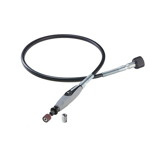

'dremel flex shaft rotary tool attachment with comfort grip and 36” long cable engraver polisher and mini sander ideal for detail metal engraving wood carving and jewelry polishing 22502 greytools home improvementdremel holiday deals25 off 125 tight spots nooks and corners theyre all easily within reach when you add the 225 flexshaft attachment to your dremel rotary tool flexible 36inch shaft attaches easily enabling craftsman jewelers woodworkers and diyers the extended control and flexibility to drill cut carve and polish even the most delicate of projects compatible with dremel rotary tool models 4300 4000 3000 200 100 8260 8250 8240 and 8220 ideal for diy or crafting projects like detail sanding carving engraving cutting cleaning and polishing integrated shaft lock button on the hand piece allows for easy accessory changes comfort grip hand piece allows finger tip control to cut grind sand sharpen polish and more quick connect easily attaches to your dremel rotary tool'

In [46]:
example = dataset[0]
image = example["image"]
width, height = image.size
display(image.resize((int(0.3*width), int(0.3*height))))

example["text"]

In [47]:
# prepare image for the model
inputs = processor(images=image, return_tensors="pt").to(device)
pixel_values = inputs.pixel_values

generated_ids = model.generate(pixel_values=pixel_values, max_length=50)
generated_caption = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
print(generated_caption)

perler pegboards ironing paper and polishing ironing paper and polishing material is ironing paper and polishing is metalic with the perler bead ironing paper and polish
